# Cargamos librerias

In [1]:
from tensorflow import keras as ks
from tensorflow.keras.applications import vgg16
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.layers import Dense, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import random
import os
import time
import datetime

In [2]:
# Paso 2: Cargar el dataset CIFAR10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Paso 3: Preprocesar los datos
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Dividir los datos en conjunto de validación
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

x_val_scaled = x_val / 255.0

# Convertir las etiquetas a one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
print("Etiquetas de train (en vector):", y_train)

Etiquetas de train (en vector): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#Obtenemos un array con todas las labels de CIFAR10

In [4]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos. Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método .get_cmap() de PlotLy con los nueve primeros números del dataset.

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


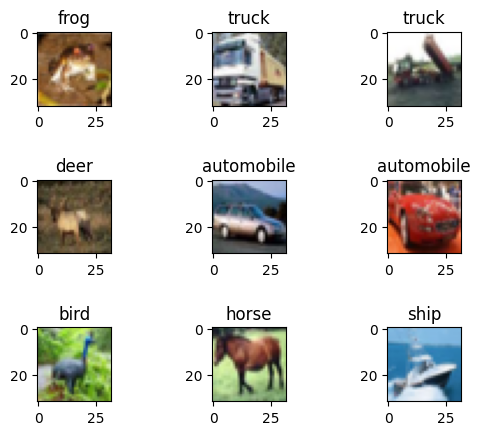

In [5]:
# Pintemos una muestra de las las imagenes del dataset MNIST
import numpy as np
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    class_index = np.argmax(y_train[i])
    plt.title(cifar10_labels[class_index])

plt.subplots_adjust(hspace=1)
plt.show()



# Modelo

In [6]:
model_vgg16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))

58889256/58889256 [==============================] - 2s 0us/step


In [7]:
output = model_vgg16.layers[-1].output  # en este paso  nos quedamos  y lo juntamos
output

<KerasTensor: shape=(None, 1, 1, 512) dtype=float32 (created by layer 'block5_pool')>

In [8]:
output_layer = ks.layers.Flatten()(output)
output_layer

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'flatten')>

In [9]:
model_prevgg16 = Model(model_vgg16.input, output_layer)
model_prevgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [10]:
import pandas as pd

In [11]:
pd.set_option("display.max_colwidth", True)
layers = [(layer, layer.name, layer.trainable) for layer in model_prevgg16.layers]
pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

,Layer,Name,Is Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7f027ee92110>,input_1,True
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027ea4b7c0>,block1_conv1,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c8f60b0>,block1_conv2,True
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f027c999420>,block1_pool,True
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c917a90>,block2_conv1,True
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c99ac80>,block2_conv2,True
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f027c999c00>,block2_pool,True
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c99b4c0>,block3_conv1,True
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c99be50>,block3_conv2,True
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c99bbb0>,block3_conv3,True


In [12]:
model_prevgg16.trainable

True

In [13]:
trainable = False
for layer in model_prevgg16.layers:
  if layer.name == "block3_conv1":
    trainable = True

  layer.trainable = trainable

In [14]:
layers = [(layer, layer.name, layer.trainable) for layer in model_prevgg16.layers]
pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

,Layer,Name,Is Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7f027ee92110>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027ea4b7c0>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c8f60b0>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f027c999420>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c917a90>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c99ac80>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f027c999c00>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c99b4c0>,block3_conv1,True
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c99be50>,block3_conv2,True
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f027c99bbb0>,block3_conv3,True


In [15]:
model_prevgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [16]:
model_post_vgg = ks.Sequential()

model_post_vgg.add(model_prevgg16)
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(512, activation='relu'))
model_post_vgg.add(ks.layers.Dropout(0.3))
model_post_vgg.add(ks.layers.Dense(1, activation='sigmoid'))

model_post_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 15,240,513
Trainable params: 14,980,353
No

In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
new_adam = Adam(learning_rate=0.00005)

In [19]:
model_post_vgg.compile(loss='binary_crossentropy', optimizer=new_adam, metrics=['accuracy'])

In [20]:
callback = EarlyStopping(monitor='val_loss', patience=5)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,

    # Definamos las transformaciones
    rotation_range=15,
    brightness_range=(0.7,1.15),
    horizontal_flip = True,
    zoom_range = 0.5
    # samplewise_std_normalization=True,
    # channel_shift_range = 3.0
    )

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=30
)

In [23]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val,
    y_val,
    batch_size=20
)

In [24]:
t = time.perf_counter()

In [25]:
history = model_post_vgg.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[callback],
                    steps_per_epoch =  167, # num_imagenes / batch size = 5000/30 = 166.6667
                    validation_steps = 50 # num_img_val / batch_size = 1000 / 20 = 50
)

elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

Epoch 1/20
167/167 [==============================] - 23s 45ms/step - loss: 0.3353 - accuracy: 0.8979 - val_loss: 0.3254 - val_accuracy: 0.9000
Epoch 2/20
167/167 [==============================] - 7s 44ms/step - loss: 0.3277 - accuracy: 0.9000 - val_loss: 0.3251 - val_accuracy: 0.9000
Epoch 3/20
167/167 [==============================] - 7s 39ms/step - loss: 0.3271 - accuracy: 0.9000 - val_loss: 0.3257 - val_accuracy: 0.9000
Epoch 4/20
167/167 [==============================] - 7s 43ms/step - loss: 0.3267 - accuracy: 0.9000 - val_loss: 0.3267 - val_accuracy: 0.9000
Epoch 5/20
167/167 [==============================] - 8s 46ms/step - loss: 0.3266 - accuracy: 0.9000 - val_loss: 0.3264 - val_accuracy: 0.9000
Epoch 6/20
167/167 [==============================] - 6s 38ms/step - loss: 0.3264 - accuracy: 0.9000 - val_loss: 0.3272 - val_accuracy: 0.9000
Epoch 7/20
167/167 [==============================] - 7s 43ms/step - loss: 0.3264 - accuracy: 0.9000 - val_loss: 0.3273 - val_accuracy: 0.900

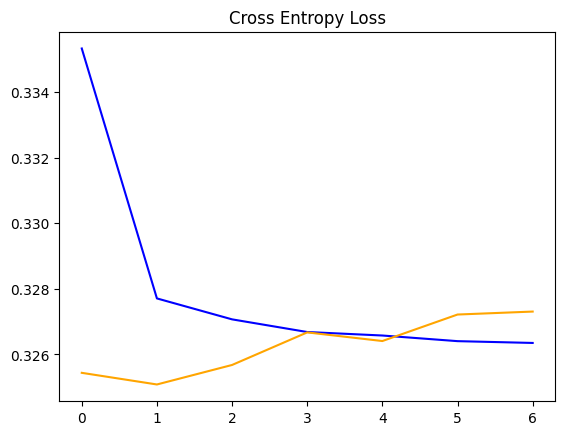

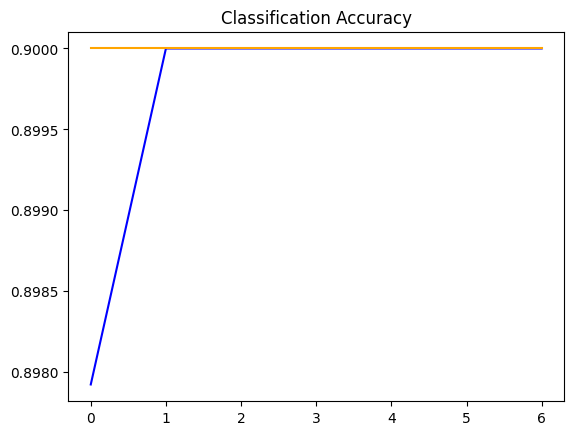

In [26]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

In [31]:
_, acc = model_post_vgg.evaluate(x_test, y_test, verbose=0)
print('Modelo binario vgg16,finetunning,capas congeladas3,+ > %.3f' % (acc * 100.0))


Modelo binario vgg16,finetunning,capas congeladas3,+ > 90.000


In [28]:
print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:01:32.948071


313/313 [==============================] - 3s 9ms/step - loss: 0.3258 - accuracy: 0.9000
Accuracy: 0.8999972939491272


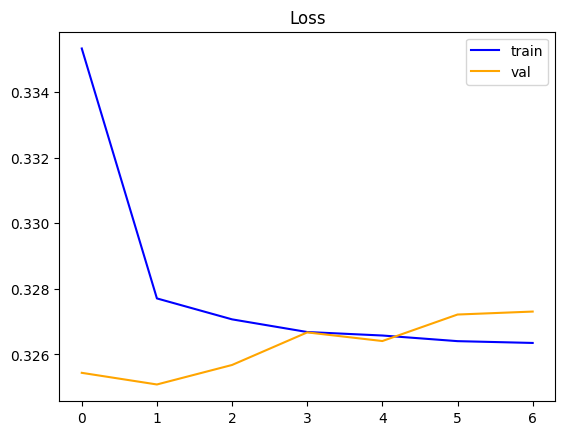

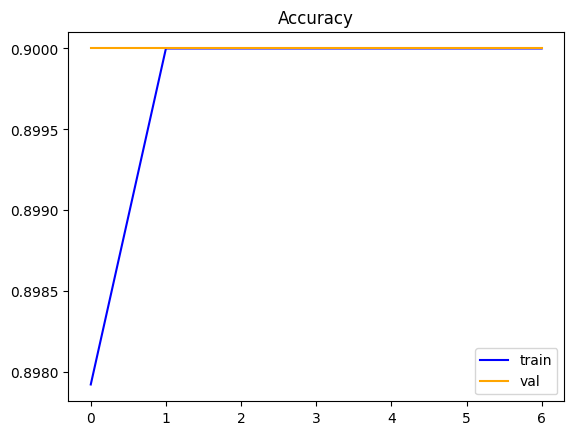

In [29]:
# Evaluar el modelo
_, accuracy = model_post_vgg.evaluate(x_test, y_test)
print('Accuracy:', accuracy)

# Plot de la pérdida durante el entrenamiento
plt.title('Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

# Plot de la precisión durante el entrenamiento
plt.title('Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

In [30]:
predictions = model.predict(x_test)

NameError: ignored

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, int(true_label[i][0]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                          100 * np.max(predictions_array),
                                          true_label),
                                          color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array = predictions_array
    true_label = int(true_label[i][0])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i + start, predictions[i + start], y_test, x_test)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i + start, predictions[i + start], y_test)
plt.tight_layout()
plt.show()


In [ ]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array = predictions_array
    true_label = int(true_label[i][0])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, int(true_label[i][0]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                          100 * np.max(predictions_array),
                                          true_label),
                                          color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i][0])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i + start, predictions[i + start], y_test, x_test)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i + start, predictions[i + start], y_test)
plt.tight_layout()
plt.show()
